# Notebook Title

## Setup Python and R environment
you can ignore this section

In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

Durante la inicialización - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 


In [3]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
%%R
#

# My commonly used R imports

require('tidyverse')
require('tidycensus')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: tidyverse
Loading required package: tidycensus


## Load & Clean Data

👉 Load the data along with the census connectors below (the output of the `connect-to-census.ipynb` notebook) and do any cleanup you'd like to do.

In [5]:
%%R
# Read the CSV file with custom delimiters
df <- read.csv('Prueba1.csv')
df

                                                               Name.STATE.COUNTY.TRACT.GEOID
1                                              100% Playground;36.0;47.0;97400.0;364797400.0


2                                          174th Street Playground;36.0;5.0;6200.0;3656200.0
3                                          227 Street Playground;36.0;5.0;40600.0;36540600.0
4                                                  Abe Lincoln;36.0;61.0;16900.0;366116900.0
5                                               Abigail Playground;36.0;5.0;7900.0;3657900.0
6                                       Agnes Haywood Playground;36.0;5.0;39000.0;36539000.0
7                                               Albemarle Park;36.0;47.0;49800.0;364749800.0
8                                  Albert J. Parham Playground;36.0;47.0;31300.0;364731300.0
9                                Alexander Hamilton Playground;36.0;61.0;25900.0;366125900.0
10                                          Alfred E. Smith Park;36.0;61.0;2500.0;36612500.0
11                                     Alice Kornegay Triangle;36.0;61.0;24200.0;366124200.0
12                                           Allerton Playground;36.0

## 👉 Grab Census Data

1. loading the Census API key

In [6]:
import dotenv

# Load the environment variables
# (loads CENSUS_API_KEY from .env)
dotenv.load_dotenv()

CENSUS_API_KEY = "a435d72f84653a5895173d187536a34d55ac0afc"

In [7]:
%%R 

require('tidycensus')

# because it an environment variable, we don't have to 
# explicitly pass this string to R, it is readable here
# in this R cell.
census_api_key(Sys.getenv("a435d72f84653a5895173d187536a34d55ac0afc"))

To install your API key for use in future sessions, run this function with `install = TRUE`.


2. Decide which Census variables you want

    Use <https://censusreporter.org/> to figure out which tables you want. (if censusreporter is down, check out the code in the cell below)

    -   Scroll to the bottom of the page to see the tables.
    -   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

    By default this code loads (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

    - find some other variables that you're also interested in
    - don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
    ).


In [8]:
%%R 

# Finding the Census Varaibles for the ACS 5 year survey
# Generall you'd do this in CensusReporter, but since it's down sometimes, here it is using tidycensus's load_variables function

# get every single variable in the ACS5
all_census_vars <- load_variables(2021, "acs5", cache = TRUE) 

filtered_census_vars <- all_census_vars %>% 
    filter(grepl("median income", label, ignore.case = TRUE))   # filter to those containing "median income"
    
# write to CSV so we can view it in python
filtered_census_vars %>% 
    write_csv("filtered_census_vars.csv")

# show the first few rows
filtered_census_vars %>%
    select(-geography) %>% # remove the geography column
    print(n = 20) # print the first 20 rows

# A tibble: 46 × 3
   name         label                                                    concept
   <chr>        <chr>                                                    <chr>  
 1 B06011PR_001 Estimate!!Median income in the past 12 months --!!Total: MEDIAN…
 2 B06011PR_002 Estimate!!Median income in the past 12 months --!!Total… MEDIAN…
 3 B06011PR_003 Estimate!!Median income in the past 12 months --!!Total… MEDIAN…
 4 B06011PR_004 Estimate!!Median income in the past 12 months --!!Total… MEDIAN…
 5 B06011PR_005 Estimate!!Median income in the past 12 months --!!Total… MEDIAN…
 6 B06011_001   Estimate!!Median income in the past 12 months --!!Total: MEDIAN…
 7 B06011_002   Estimate!!Median income in the past 12 months --!!Total… MEDIAN…
 8 B06011_003   Estimate!!Median income in the past 12 months --!!Total… MEDIAN…
 9 B06011_004   Estimate!!Median income in the past 12 months --!!Total… MEDIAN…
10 B06011_005   Estimate!!Median income in the past 12 months --!!Total… MEDIAN…
11 B07011

In [9]:
%%R -o nyc_census_data
# the variable B01003_001E was selectd from the census table 
# for population, which we found in censusreporter here:
# https://censusreporter.org/tables/B01003/

# in the table below, pick the geography, the variables, and the survey you want to pull from
# see the possible values here https://walker-data.com/tidycensus/articles/basic-usage.html

# Get variable from ACS
nyc_census_data <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        population="B01003_001",
                        med_inc="B19013_001",
                        poverty="B17001_001"
                      ), 
                      year = 2021,
                      survey="acs5",
                      geometry=F)

nyc_census_data

# A tibble: 6,981 × 5
   GEOID       NAME                                    variable   estimate   moe
   <chr>       <chr>                                   <chr>         <dbl> <dbl>
 1 36005000100 Census Tract 1, Bronx County, New York  population     6661   702
 2 36005000100 Census Tract 1, Bronx County, New York  poverty           0    18
 3 36005000100 Census Tract 1, Bronx County, New York  med_inc          NA    NA
 4 36005000200 Census Tract 2, Bronx County, New York  population     4453   563
 5 36005000200 Census Tract 2, Bronx County, New York  poverty        4453   563
 6 36005000200 Census Tract 2, Bronx County, New York  med_inc       70867 25423
 7 36005000400 Census Tract 4, Bronx County, New York  population     6000   903
 8 36005000400 Census Tract 4, Bronx County, New York  poverty        6000   903
 9 36005000400 Census Tract 4, Bronx County, New York  med_inc       98090 18180
10 36005001600 Census Tract 16, Bronx County, New York population     6038   665
# ℹ 6,

Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'
Además: Warning message:
• You have not set a Census API key. Users without a key are limited to 500
queries per day and may experience performance limitations.
ℹ For best results, get a Census API key at
http://api.census.gov/data/key_signup.html and then supply the key to the
`census_api_key()` function to use it throughout your tidycensus session.
This warning is displayed once per session. 


In [10]:
nyc_census_data

,GEOID,NAME,variable,estimate,moe
1,36005000100,"Census Tract 1, Bronx County, New York",population,6661.0,702.0
2,36005000100,"Census Tract 1, Bronx County, New York",poverty,0.0,18.0
3,36005000100,"Census Tract 1, Bronx County, New York",med_inc,NaN,NaN
4,36005000200,"Census Tract 2, Bronx County, New York",population,4453.0,563.0
5,36005000200,"Census Tract 2, Bronx County, New York",poverty,4453.0,563.0
...,...,...,...,...,...
6977,36085032300,"Census Tract 323, Richmond County, New York",poverty,1105.0,304.0
6978,36085032300,"Census Tract 323, Richmond County, New York",med_inc,86471.0,25095.0
6979,36085990100,"Census Tract 9901, Richmond County, New York",population,0.0,13.0
6980,36085990100,"Census Tract 9901, Richmond County, New York",poverty,0.0,13.0


In [11]:
Toilet_df = pd.read_excel('ToiletWithGeos.xlsx', dtype={'GEOID': str}) 
Toilet_df['GEOID'] = Toilet_df['GEOID'].astype(str).str[:11]

Toilet_df

,Name,Location,Open Year-Round,Handicap Accessible,Borough,Comments,Latitude,Longitude,GEOID,STATE,COUNTY,TRACT,BLOCK
0,100% Playground,"Glenwood Road, East 100 & East 101 streets",Yes,NaN,Brooklyn,NaN,40.646908,-73.899467,36047097400,36,47,97400,2002
1,174th Street Playground,"East 174 Street, Stratford Avenue, Bronx River...",Yes,NaN,Bronx,NaN,40.833885,-73.876596,36005006200,36,5,6200,3000
2,227 Street Playground,Bronx Boulevard between East 226 and East 228 ...,Yes,Yes,Bronx,NaN,40.888553,-73.855013,36005040600,36,5,40600,1001
3,Abe Lincoln,"East 135 Street, between Madison & 5 avenues",Yes,NaN,Manhattan,NaN,40.783060,-73.971249,36061016900,36,61,16900,6000
4,Abigail Playground,"East 156 Street, Tinton Avenue",No,NaN,Bronx,NaN,40.817880,-73.905006,36005007900,36,5,7900,1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,Wingate Park,Brooklyn Avenue & Rutland Road,Yes,NaN,Brooklyn,NaN,40.659723,-73.945358,36047081000,36,47,81000,1004
612,Woods Playground,Bergen Street & Utica Avenue,Yes,NaN,Brooklyn,NaN,40.675045,-73.930540,36047030900,36,47,30900,2000
613,Woodtree Playground,"20 Avenue, 37 Street, 38 Street",Yes,NaN,Queens,NaN,40.761101,-73.919665,36081006100,36,81,6100,4001
614,Yak Playground,Avenue Y between Coyle & Batchelder streets,Yes,Yes,Brooklyn,NaN,40.595089,-73.937972,36047057200,36,47,57200,2001


In [12]:
nyc_census_data[nyc_census_data['GEOID'] == '36047097400']

,GEOID,NAME,variable,estimate,moe
3232,36047097400,"Census Tract 974, Kings County, New York",population,2792.0,536.0
3233,36047097400,"Census Tract 974, Kings County, New York",poverty,2464.0,417.0
3234,36047097400,"Census Tract 974, Kings County, New York",med_inc,76767.0,17732.0


In [13]:
merge = Toilet_df.merge(nyc_census_data, left_on='GEOID', right_on='GEOID')
merge

merge.to_excel('merged.xlsx', index=False)

In [15]:
merge

,Name,Location,Open Year-Round,Handicap Accessible,Borough,Comments,Latitude,Longitude,GEOID,STATE,COUNTY,TRACT,BLOCK,NAME,variable,estimate,moe
0,100% Playground,"Glenwood Road, East 100 & East 101 streets",Yes,NaN,Brooklyn,NaN,40.646908,-73.899467,36047097400,36,47,97400,2002,"Census Tract 974, Kings County, New York",population,2792.0,536.0
1,100% Playground,"Glenwood Road, East 100 & East 101 streets",Yes,NaN,Brooklyn,NaN,40.646908,-73.899467,36047097400,36,47,97400,2002,"Census Tract 974, Kings County, New York",poverty,2464.0,417.0
2,100% Playground,"Glenwood Road, East 100 & East 101 streets",Yes,NaN,Brooklyn,NaN,40.646908,-73.899467,36047097400,36,47,97400,2002,"Census Tract 974, Kings County, New York",med_inc,76767.0,17732.0
3,174th Street Playground,"East 174 Street, Stratford Avenue, Bronx River...",Yes,NaN,Bronx,NaN,40.833885,-73.876596,36005006200,36,5,6200,3000,"Census Tract 62, Bronx County, New York",population,6710.0,809.0
4,174th Street Playground,"East 174 Street, Stratford Avenue, Bronx River...",Yes,NaN,Bronx,NaN,40.833885,-73.876596,36005006200,36,5,6200,3000,"Census Tract 62, Bronx County, New York",poverty,6710.0,809.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837,Woodtree Playground,"20 Avenue, 37 Street, 38 Street",Yes,NaN,Queens,NaN,40.761101,-73.919665,36081006100,36,81,6100,4001,"Census Tract 61, Queens County, New York",poverty,5432.0,795.0
1838,Woodtree Playground,"20 Avenue, 37 Street, 38 Street",Yes,NaN,Queens,NaN,40.761101,-73.919665,36081006100,36,81,6100,4001,"Census Tract 61, Queens County, New York",med_inc,100067.0,14225.0
1839,Zimmerman Playground,"Britton Street, Barker Avenue, Olinville Avenue",No,NaN,Bronx,NaN,40.866610,-73.869158,36005033601,36,5,33601,2001,"Census Tract 336.01, Bronx County, New York",population,4925.0,767.0
1840,Zimmerman Playground,"Britton Street, Barker Avenue, Olinville Avenue",No,NaN,Bronx,NaN,40.866610,-73.869158,36005033601,36,5,33601,2001,"Census Tract 336.01, Bronx County, New York",poverty,4890.0,767.0


## 👉 Merge it with your data

hint...`tidycensus` provides you data in long format you may need to pivot the census data from long to wide format before merging it with your data

In [17]:
import pandas as pd

# Assuming df is your DataFrame
# Adjust the column names as necessary to match your DataFrame

pivot_merge = merge.pivot_table(index=['Name', 'Location', 'Latitude', 'Longitude', 'Borough'], 
                          columns='variable', 
                          values='estimate', 
                          aggfunc='first').reset_index()

# 'aggfunc' is used to resolve multiple values for the same index/column combination.
# 'first' means taking the first value encountered. You can change it to 'mean' or another
# appropriate aggregation function depending on your data.

print(pivot_merge.head())


variable                     Name  \
0                 100% Playground   
1         174th Street Playground   
2           227 Street Playground   
3                     Abe Lincoln   
4              Abigail Playground   

variable                                           Location   Latitude  \
0                Glenwood Road, East 100 & East 101 streets  40.646908   
1         East 174 Street, Stratford Avenue, Bronx River...  40.833885   
2         Bronx Boulevard between East 226 and East 228 ...  40.888553   
3              East 135 Street, between Madison & 5 avenues  40.783060   
4                            East 156 Street, Tinton Avenue  40.817880   

variable  Longitude    Borough   med_inc  population  poverty  
0        -73.899467   Brooklyn   76767.0      2792.0   2464.0  
1        -73.876596      Bronx   24769.0      6710.0   6710.0  
2        -73.855013      Bronx   45982.0      3997.0   3990.0  
3        -73.971249  Manhattan  153854.0      7984.0   7921.0  
4        -73

In [18]:
pivot_merge

variable,Name,Location,Latitude,Longitude,Borough,med_inc,population,poverty
0,100% Playground,"Glenwood Road, East 100 & East 101 streets",40.646908,-73.899467,Brooklyn,76767.0,2792.0,2464.0
1,174th Street Playground,"East 174 Street, Stratford Avenue, Bronx River...",40.833885,-73.876596,Bronx,24769.0,6710.0,6710.0
2,227 Street Playground,Bronx Boulevard between East 226 and East 228 ...,40.888553,-73.855013,Bronx,45982.0,3997.0,3990.0
3,Abe Lincoln,"East 135 Street, between Madison & 5 avenues",40.783060,-73.971249,Manhattan,153854.0,7984.0,7921.0
4,Abigail Playground,"East 156 Street, Tinton Avenue",40.817880,-73.905006,Bronx,22534.0,7157.0,7151.0
...,...,...,...,...,...,...,...,...
602,Wingate Park,Brooklyn Avenue & Rutland Road,40.659723,-73.945358,Brooklyn,63362.0,2530.0,2361.0
603,Woods Playground,Bergen Street & Utica Avenue,40.675045,-73.930540,Brooklyn,59484.0,2444.0,2410.0
604,Woodtree Playground,"20 Avenue, 37 Street, 38 Street",40.761101,-73.919665,Queens,100067.0,5474.0,5432.0
605,Yak Playground,Avenue Y between Coyle & Batchelder streets,40.595089,-73.937972,Brooklyn,25498.0,5394.0,5394.0


In [40]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster

# Load and clean your dataset
df = merge  # Update this path
df = df.drop_duplicates(subset=['Latitude', 'Longitude'])

# Initialize the map
start_location = [df.iloc[0]['Latitude'], df.iloc[0]['Longitude']]
map = folium.Map(location=start_location, zoom_start=12)

# Create a MarkerCluster
marker_cluster = MarkerCluster().add_to(map)

# Add markers to the map
for index, row in df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Name']}, {row['Borough']}, Open Year-Round: {row['Open Year-Round']}",
        tooltip=row['Name']
    ).add_to(marker_cluster)

# Save the map to an HTML file once
map.save('map.html')


Borough
Brooklyn         507
Queens           483
Manhattan        387
Bronx            351
Staten Island    114
Name: count, dtype: int64

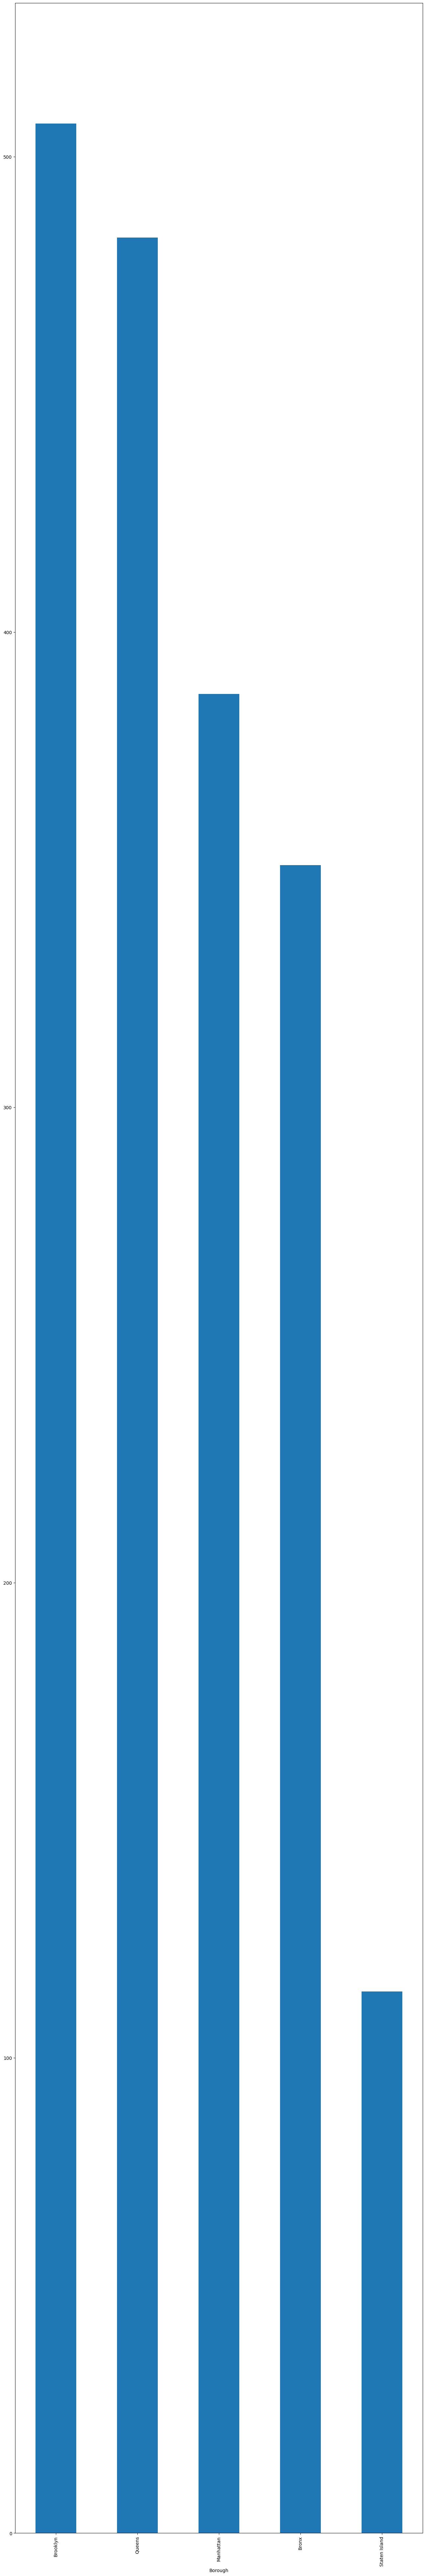

In [38]:
# plot the amount of name in each borough
merge['Borough'].value_counts().plot(kind='bar')

merge['Borough'].value_counts()




In [ ]:
%%R
library(readr)
library(dplyr)

# Read the original ToiletWithGeos (2) CSV file
toilet_df <- read_csv("ToiletWithGeos (2).csv")

# Modify "COUNTY" column as done previously
toilet_df <- toilet_df %>%
  mutate(COUNTY = if_else(COUNTY == 5, sprintf("%03d", COUNTY), sprintf("%02d", COUNTY)))

# Ensure "TRACT" is six digits
toilet_df <- toilet_df %>%
  mutate(TRACT = sprintf("%06d", TRACT))

# Create "GEOIDCORRECT" by merging "STATE", "COUNTY", and "TRACT"
toilet_df <- toilet_df %>%
  mutate(GEOIDCORRECT = paste0(STATE, COUNTY, TRACT))

# Read the cleaned census_data CSV file (assuming it has been cleaned as described)
census_df <- read_csv("path/to/your/cleaned_census_data.csv", col_types = cols(
  GEOIDCORRECT = col_character(),
  NAME = col_character(),
  variable = col_character(),
  estimate = col_double()
))

# Merge the two data frames on "GEOIDCORRECT"
merged_df <- merge(toilet_df, census_df, by = "GEOIDCORRECT")

# Write the merged DataFrame to a new CSV file
write_csv(merged_df, "Final_Merged_Dataset.csv")

# Note: Replace "path/to/your/" with the actual file paths for your datasets


New names:
• `SUFFIX` -> `SUFFIX...9`
• `POP100` -> `POP100...10`
• `GEOID` -> `GEOID...11`
• `CENTLAT` -> `CENTLAT...12`
• `BLOCK` -> `BLOCK...13`
• `AREAWATER` -> `AREAWATER...14`
• `STATE` -> `STATE...15`
• `BASENAME` -> `BASENAME...16`
• `OID` -> `OID...17`
• `LSADC` -> `LSADC...18`
• `INTPTLAT` -> `INTPTLAT...19`
• `FUNCSTAT` -> `FUNCSTAT...20`
• `NAME` -> `NAME...21`
• `OBJECTID` -> `OBJECTID...22`
• `TRACT` -> `TRACT...23`
• `CENTLON` -> `CENTLON...24`
• `BLKGRP` -> `BLKGRP...25`
• `AREALAND` -> `AREALAND...26`
• `HU100` -> `HU100...27`
• `INTPTLON` -> `INTPTLON...28`
• `MTFCC` -> `MTFCC...29`
• `LWBLKTYP` -> `LWBLKTYP...30`
• `UR` -> `UR...31`
• `COUNTY` -> `COUNTY...32`
• `SUFFIX` -> `SUFFIX...33`
• `POP100` -> `POP100...34`
• `GEOID` -> `GEOID...35`
• `CENTLAT` -> `CENTLAT...36`
• `BLOCK` -> `BLOCK...37`
• `AREAWATER` -> `AREAWATER...38`
• `STATE` -> `STATE...39`
• `BASENAME` -> `BASENAME...40`
• `OID` -> `OID...41`
• `LSADC` -> `LSADC...42`
• `INTPTLAT` -> `INTPTLAT...43`
• 

RInterpreterError: Failed to parse and evaluate line 'library(readr)\nlibrary(dplyr)\n\n# Read the original ToiletWithGeos (2) CSV file\ntoilet_df <- read_csv("ToiletWithGeos (2).csv")\n\n# Modify "COUNTY" column as done previously\ntoilet_df <- toilet_df %>%\n  mutate(COUNTY = if_else(COUNTY == 5, sprintf("%03d", COUNTY), sprintf("%02d", COUNTY)))\n\n# Ensure "TRACT" is six digits\ntoilet_df <- toilet_df %>%\n  mutate(TRACT = sprintf("%06d", TRACT))\n\n# Create "GEOIDCORRECT" by merging "STATE", "COUNTY", and "TRACT"\ntoilet_df <- toilet_df %>%\n  mutate(GEOIDCORRECT = paste0(STATE, COUNTY, TRACT))\n\n# Read the cleaned census_data CSV file (assuming it has been cleaned as described)\ncensus_df <- read_csv("path/to/your/cleaned_census_data.csv", col_types = cols(\n  GEOIDCORRECT = col_character(),\n  NAME = col_character(),\n  variable = col_character(),\n  estimate = col_double()\n))\n\n# Merge the two data frames on "GEOIDCORRECT"\nmerged_df <- merge(toilet_df, census_df, by = "GEOIDCORRECT")\n\n# Write the merged DataFrame to a new CSV file\nwrite_csv(merged_df, "Final_Merged_Dataset.csv")\n\n# Note: Replace "path/to/your/" with the actual file paths for your datasets\n'.
R error message: 'Error in mutate(., COUNTY = if_else(COUNTY == 5, sprintf("%03d", COUNTY),  : \n  \nCaused by error:\n! objeto \'COUNTY\' no encontrado'